# COMP3222/COMP6246 Machine Learning Technologies (2018/19)

## Week 11 - Recurrent Neural Networks (Chapter 14)

Follow each section at your own pace, you can have a look at the book or ask questions to demonstrators if you find something confusing.

# 1. Basic Theory

Until now, we looked into basic preceptrons, convolutional neural network (CNN) and how to implement them in TensorFlow. In practice these techniques are used in tasks such as: searching images, self-driving cars, automatic video classification and many more. Surely, there are different network architectures that are used in Deep Learning. In the previous lab, we showed that CNNs are essentially for `"processing a grid of values"`. However, the Deep Learning community has also generated another architecture specifically for `"processing a sequence of values"`, which are called **Recurrent Neural Networks (RNN)** [Goodfellow 2016]. In practice, recurrent neural networks are used for analyzing time series: stock prices, car trajectories, sentiment analysis and more. 

_Get Motivated_: Have a look at [this interactive example](https://distill.pub/2016/handwriting/), which generates new strokes in your handwriting style using RNNs. The model is explained in [this paper](https://arxiv.org/abs/1308.0850).

## Bare-bones RNN

Let's implement an RNN with five recurrent neurons without using TensorFlow's RNN implementation/utilities. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()
# Let's assume some artificial data with three input (if our objective is to predict words in a sentence
n_inputs = 3  # then for instance: first word, second word, third word can be the input of our model)
n_neurons = 5 # number of neurons

X0 = tf.placeholder(tf.float32, [None, n_inputs]) # t=0 batch
X1 = tf.placeholder(tf.float32, [None, n_inputs]) # t=1 batch

# Weights on inputs (all steps share this), initialy they are set random
Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))

# Connection weights for the outputs of the previous timestep (all steps share this), initialy they are set random 
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))

# bias vector, all zeros for now
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

# outputs of timestep 0
Y0 = tf.tanh(tf.matmul(X0, Wx) + b)

# outputs of timestep 1
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)
# Y1 = activation_function(dot_product(Y0, Wy) + dot_product(X1, Wx) + bias_vector)

init = tf.global_variables_initializer()

# Mini-batch:        instance1  instance2   instance3 instance4
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0 
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1 

# within the session
with tf.Session() as sess:
    init.run()
    # get the outputs of each step
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [2]:
print(Y0_val) # layers output at t=0

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [3]:
print(Y1_val) # layers output at t=1

[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


For the given example above, from the comments in the code:

***Exercise 1.2.*: How would you define the outputs?**

Have a look at page 386 of your book, Figure 14_1. These are the outputs of each neuron in an RNN.

***Exercise 1.3.*: Why are there five columns?**

Because, there are five neurons.

***Exercise 1.4.*: Why are there four rows?**

You are providing four training samples of the data.

***Exercise 1.5.*: What would be the difference between `instance1` at $t=0$ and `instance1` at $t=1$?**

They are not related. In this example, they are two batches of different data points. 

***Exercise 1.6.*: What is the difference between `instance1` and `instance2` at $t=1$?**

We are supplying four training samples in each two batches. Therefore, they are just different data points. 

# 2. Predicting Time Series

Let's look at a simple use of RNNs with time series, these time series could be stock prices, brain wave patterns and so on. Our objective could be predicting the future stock price, given the available data that we have.

Let's define an arbitary sine function for stock prices `time_series(t)` to make our predictions. 

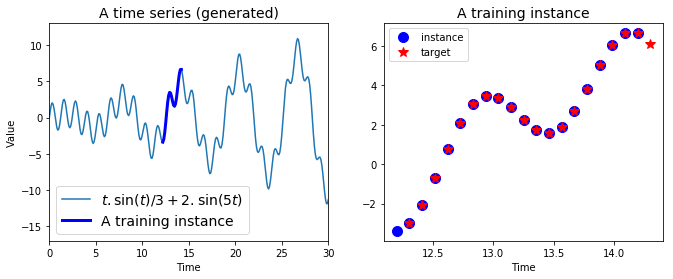

In [4]:
reset_graph()
# time starts from 0 to 30
t_min, t_max = 0, 30
# we sample time_series function for every 0.1 
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    """
    Returns a batch with `n_steps`: number of instances
    """
    # randomly get a starting number between a range
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    # make a list until of number with n_steps until the next batch
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    # get the outputs of time_series function given the input Ts (time points)
    ys = time_series(Ts)
    
    # return X's and Y's
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

# inputs to the time_series function
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
# a training instance
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
# plot all the data
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")

# plot only the training set
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
# notice that targets are shifted by one time step into the future
plt.plot(t_instance[1:], time_series(t_instance[1:]), "r*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [5]:
X_batch, y_batch = next_batch(1, n_steps)

# combining X_batch and y_batch for better printing, first_column=X, second_column=Y
print(np.c_[X_batch[0], y_batch[0]])
# Did you notice the shift in y values?

[[-1.40208096 -2.33035999]
 [-2.33035999 -3.4513234 ]
 [-3.4513234  -4.52641909]
 [-4.52641909 -5.32081479]
 [-5.32081479 -5.66045846]
 [-5.66045846 -5.47433377]
 [-5.47433377 -4.81157012]
 [-4.81157012 -3.82922233]
 [-3.82922233 -2.75371563]
 [-2.75371563 -1.82539786]
 [-1.82539786 -1.23977629]
 [-1.23977629 -1.0998269 ]
 [-1.0998269  -1.39105208]
 [-1.39105208 -1.98539218]
 [-1.98539218 -2.67303091]
 [-2.67303091 -3.214304  ]
 [-3.214304   -3.39899794]
 [-3.39899794 -3.09851497]
 [-3.09851497 -2.29812628]
 [-2.29812628 -1.10140997]]


In [44]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
learning_rate = 0.001
n_iterations = 1500
batch_size = 50


# Optimizer that finds the weight values for each neuron
def get_predictions(optimizer="gdo", 
                    loss_function="mse",
                    save=False,
                    reset=True):
    reset_graph()   
    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

    # We use `dynamic_rnn` and `BasicRNNCell` utilities in this case, with tf.nn.relu
    cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

    # This part is visually shown in the book Figure 14-10.
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])

    # What do you think line below will be doing? (Tip: https://www.tensorflow.org/api_docs/python/tf/layers/dense)
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)

    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    
    if optimizer == "gdo":
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    elif optimizer == "adam":
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        
    
    # The loss function to optimize
    if loss_function == "mse":
        loss = tf.reduce_mean(tf.square(outputs - y))
    elif loss_function == "rmse":
        loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(outputs, y)))

    # Let the optimizer know that this is the loss function to optimize
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    y_pred = None
    with tf.Session() as sess:
        init.run()
        for iteration in range(n_iterations):
            # get a random batch 
            X_batch, y_batch = next_batch(batch_size, n_steps)
            # run tensorflow session
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            # in each 100th iteration
            if iteration % 100 == 0: # with RSME
                loss_val = loss.eval(feed_dict={X: X_batch, y: y_batch})
                # print the MSE
                print(iteration, "\t{}:".format(loss_function), loss_val)

        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        if save:
            saver.save(sess, "./my_time_series_model_" + loss_function)
    if reset:
        reset_graph()   
    
    return y_pred, saver, outputs, X

In [45]:

y_mse_pred, _, _, _ = get_predictions(optimizer="gdo", loss_function="mse")
y_rmse_pred, _, _, _ = get_predictions(optimizer="gdo", loss_function="rmse", save=True)
y_mse_pred, y_rmse_pred

0 	mse: 13.841028
100 	mse: 0.9208842
200 	mse: 0.5451864
300 	mse: 0.3608686
400 	mse: 0.29775763
500 	mse: 0.26228666
600 	mse: 0.2378313
700 	mse: 0.18191071
800 	mse: 0.1791766
900 	mse: 0.1877928
1000 	mse: 0.16793789
1100 	mse: 0.16937838
1200 	mse: 0.13637924
1300 	mse: 0.14248334
1400 	mse: 0.116241716
0 	rmse: 3.865088
100 	rmse: 1.8601372
200 	rmse: 1.192353
300 	rmse: 0.95981115
400 	rmse: 0.76839846
500 	rmse: 0.68166286
600 	rmse: 0.614433
700 	rmse: 0.52781844
800 	rmse: 0.50772667
900 	rmse: 0.5024867
1000 	rmse: 0.46224207
1100 	rmse: 0.453847
1200 	rmse: 0.40255177
1300 	rmse: 0.40182605
1400 	rmse: 0.3616497


(array([[[-3.547694  ],
         [-3.021121  ],
         [-1.3002949 ],
         [ 0.50973046],
         [ 2.301383  ],
         [ 3.040935  ],
         [ 3.492101  ],
         [ 3.451352  ],
         [ 2.7930226 ],
         [ 2.2292368 ],
         [ 1.5455699 ],
         [ 1.2409335 ],
         [ 1.5544994 ],
         [ 2.3978555 ],
         [ 3.6025274 ],
         [ 4.7165213 ],
         [ 5.7144103 ],
         [ 6.5561185 ],
         [ 6.739315  ],
         [ 6.248346  ]]], dtype=float32), array([[[-3.508387  ],
         [-3.0818272 ],
         [-1.3413686 ],
         [ 0.51043344],
         [ 2.2689338 ],
         [ 3.0400453 ],
         [ 3.4817753 ],
         [ 3.4555733 ],
         [ 2.7951522 ],
         [ 2.2374117 ],
         [ 1.550476  ],
         [ 1.234394  ],
         [ 1.5314184 ],
         [ 2.361004  ],
         [ 3.55357   ],
         [ 4.6712966 ],
         [ 5.7336907 ],
         [ 6.549403  ],
         [ 6.7378464 ],
         [ 6.265316  ]]], dtype=float32))

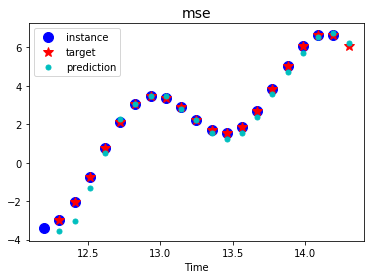

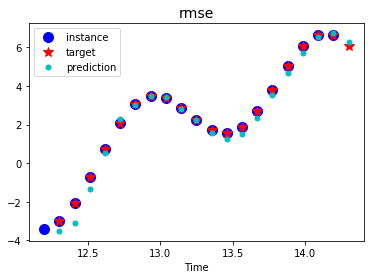

In [46]:
def plot_results(title, y_vals):
    plt.title(title, fontsize=14)
    plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
    plt.plot(t_instance[1:], time_series(t_instance[1:]), "r*", markersize=10, label="target")
    plt.plot(t_instance[1:], y_vals[0,:,0], "c.", markersize=10, label="prediction")
    plt.legend(loc="upper left")
    plt.xlabel("Time")

    plt.show()


plot_results("mse", y_mse_pred)
plot_results("rmse", y_rmse_pred)

***Exercise 2.1.* Add comments to the code blocks above. Do you understand the purpose of each line?**

Check the code blocks above.

***Exercise 2.2.* How can you improve the `MSE`? _(Tip: Remember Lab 4: Gradient Descent)_**

The code blocks above are updated with a lower learning rate and higher epoch time.

***Exercise 2.3.* Implement the `RMSE` instead of the `MSE`, compare the test plots.**

Implemented above. Difference is quite minimal in the plots.

# 3. Generative RNNs

We can use RNNs to generate sequences, below you are going to use the model we trained. You should expect some resemblance to the original time series. 

0 	mse: 13.907029
100 	mse: 0.5056698
200 	mse: 0.19735886
300 	mse: 0.101214476
400 	mse: 0.06850145
500 	mse: 0.06291986
600 	mse: 0.055129297
700 	mse: 0.049436502
800 	mse: 0.050434686
900 	mse: 0.0482007
1000 	mse: 0.04809868
1100 	mse: 0.04982501
1200 	mse: 0.041912545
1300 	mse: 0.049292978
1400 	mse: 0.043140374
INFO:tensorflow:Restoring parameters from ./my_time_series_model_mse


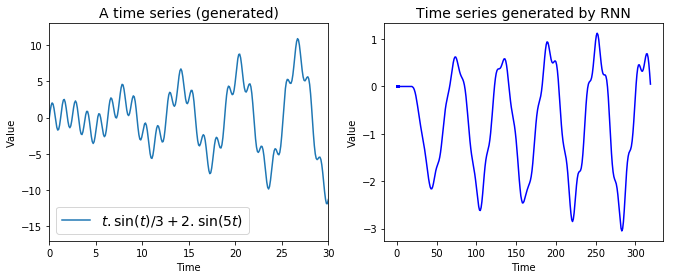

In [50]:
# since the graph is reset, let's train again:
loss_function = "mse"
_, saver, outputs, X = get_predictions(optimizer="adam", loss_function=loss_function, save=True, reset=False) 

with tf.Session() as sess:                     
    saver.restore(sess, "./my_time_series_model_"+loss_function)

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])
        
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
# plot all the data
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")


plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("Time series generated by RNN", fontsize=14)

plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")


plt.show()



***Exercise 3.1.* Does your plot resemble the actual time series? Why do you think so?**

You should notice that if your improve your errors, the time series generated would resemble to the actual time series.

***Exercise 3.2.* Change your optimizer to `AdamOptimizer`, what do you think has changed?**

The code is now more structed, please try with different parameters.

***Exercise 3.3.* Try different activation functions. (e.g. logit, tanh,  ...)**

Have a look at the generate_predictions function. Follow the same pattern and implement the other activation function and compare the time series & errors.


# Recap

In this lab, we demonstrated these concepts:

* from theory to implementation, how a simple RNN is works
* how to predict a time series with RNN 
* which parameters to look out for in order to improve the predictions
* generation of sequences with a RNN

As in the previous labs, there is some material that we have not been able to cover. In your free time, you can have a look at:

* LTSM Cells and GRU Cells
* NLP Applications with RNNs
* Encoding and Decoding with RNNs

### References
[Goodfellow, 2016] : https://www.deeplearningbook.org/